In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import entropy

In [2]:
plt.rcParams["figure.subplot.left"] = 0.22
plt.rcParams["figure.subplot.right"] = 0.95
plt.rcParams["figure.subplot.bottom"] = 0.20
plt.rcParams["figure.subplot.top"] = 0.95
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['font.size'] = 22
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.5

(4, 4)


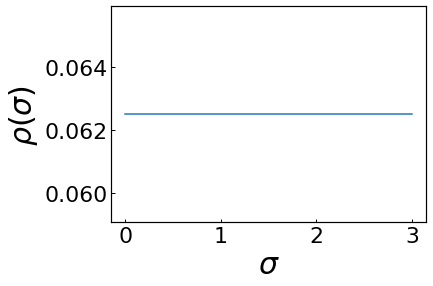

In [3]:
sigma = np.arange(0,4)
tau  = np.arange(0,4)

def _rho(sigma, tau):
    # uniform distribution
    n_sigma = sigma.shape[0]
    n_tau = tau.shape[0]
    ro = np.full( (n_sigma,n_tau), 1.0/(n_sigma*n_tau) )  # uniform distribution
    return ro

rho = _rho(sigma, tau)
print(rho.shape)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\rho(\sigma)$")
plt.plot(sigma, rho[:,0])
#plt.plot(h_tau, rho[0,:])

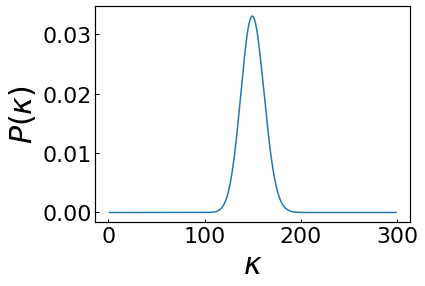

In [4]:
def _p_kappa(kappa):
    # delta function
    #return np.where(kappa == 150, 1, 0)
    # binomial distribution
    _n = 5000
    _p = 0.03
    b = binom(_n, _p)
    pmf = b.pmf(kappa)
    return pmf / np.sum(pmf)   # normalize to reduce error
    #_k = np.copy(kappa)
    #p = _k ** (-3.0)
    #_k[0] = 0.0
    #_k[1] = 0.0
    #_k[2] = 0.0
    #return p / np.sum(p)


kappa = np.arange(1,300)
P_kappa = _p_kappa(kappa)
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$P(\kappa)$")
plt.xscale("linear")
plt.yscale("linear")
plt.plot(kappa,P_kappa)

In [5]:
sigma_max = np.max(sigma)
tau_max = np.max(tau)

def r(sigma1,tau1,sigma2,tau2):
    # x = np.maximum(sigma1,sigma2)*0.0 + np.minimum(tau1,tau2) + 1.0
    # return (x / (tau_max+1) )
    # x = (np.maximum(sigma1,sigma2)+0)*(np.minimum(tau1,tau2)+1)
    # return (x / ((sigma_max+1)*(tau_max+1)))
    c = 2
    x = np.maximum(sigma1,sigma2) + c*np.minimum(tau1,tau2)
    return (x / (sigma_max+tau_max*c))
    # x = (sigma1==sigma2)*(sigma1+1)+ np.minimum(tau1,tau2)
    # return (x / (sigma_max+tau_max+1))
    # x = (sigma1==sigma2)*(sigma1+1)+(tau1==tau2)*(tau1+1)
    # return (x / (sigma_max+tau_max+2))

s1 = np.array([0,1,2])
r(s1, 1, 2, 1)

sigma_max,tau_max

(3, 3)

In [6]:
class NodalSampling:
    
    def __init__(self, sigma, tau, kappa, rho_h, P_kappa, r):
        self.sigma = sigma
        self.nsigma = sigma.shape[0]
        self.tau = tau
        self.ntau = tau.shape[0]
        
        self.kappa = kappa
        self.nkappa = kappa.shape[0]
        self.rho_h = rho_h
        assert( rho_h.shape == (self.nsigma, self.ntau) )
        self.P_kappa = P_kappa
        assert( P_kappa.shape == kappa.shape )
        self.r = r
        self.k = np.arange(0, np.amax(self.kappa)+1)
        self.nk = self.k.shape[0]
        self.results = {
            "r_bar_h": None,
            "r_bar": None,
            "g": None,
            "P_k": None,
            "r_nn_h": None,
            "p_hprime_given_h": None,
            "c_h": None,
            "g_star": None
        }
        
    def r_bar_h(self):
        # sum_{h'} rho(h') r(h,h')
        if self.results["r_bar_h"] is not None:
            return self.results["r_bar_h"]
        # axis (sigma1, tau1, sigma2, tau2)
        sigma2 = np.copy(self.sigma).reshape((1,1,self.nsigma,1))
        tau2 = np.copy(self.tau).reshape((1,1,1,self.ntau))
        sigma1 = self.sigma.reshape( (self.nsigma,1,1,1) )
        tau1 = self.tau.reshape( (1,self.ntau,1,1) )
        rhh = self.r(sigma1, tau1, sigma2, tau2)
        dr = rhh * self.rho_h.reshape( (1,1,self.nsigma,self.ntau) )
        self.results["r_bar_h"] = np.sum(dr,axis=(2,3))
        return self.results["r_bar_h"]
    
    def r_bar(self):
        # sum_{h,h'} rho(h') rho(h) r(h,h')
        if self.results["r_bar"] is not None:
            return self.results["r_bar"]
        y = self.r_bar_h() * self.rho_h
        self.results["r_bar"] = np.sum(y, axis=(0,1))
        return self.results["r_bar"]
    
    def g(self):
        # g(k|h,kappa) = \binom(kappa, k) r(h)^k ( 1-r(h))^{kappa-k}
        #   k,sigma,tau,kappa are 0th,1st,2nd,3rd axis, respectively
        if self.results["g"] is not None:
            return self.results["g"]
        _p = self.r_bar_h().reshape( (1,self.nsigma,self.ntau,1) )
        _kappa = self.kappa.reshape( (1,1,1,self.nkappa) )
        b = binom(_kappa, _p)
        _k = self.k.reshape( (self.nk,1,1,1) )
        self.results["g"] = b.pmf(_k)
        return self.results["g"]
    
    def P_k(self):
        if self.results["P_k"] is not None:
            return self.results["P_k"]
        _g = g * self.rho_h.reshape( (1,self.nsigma,self.ntau,1) ) * self.P_kappa.reshape( (1,1,1,self.nkappa) )
        self.results["P_k"] = np.sum(_g, axis=(1,2,3))
        return self.results["P_k"]
    
    def r_nn_h(self):
        # sigma1,tau1, sigma2,tau2 are axis=0,1,2,3, respectively.
        if self.results["r_nn_h"] is not None:
            return self.results["r_nn_h"]
        sigma2 = np.copy(self.sigma).reshape([1,1,self.nsigma,1])
        tau2 = np.copy(self.tau).reshape([1,1,1,self.ntau])
        rho_h2 = self.rho_h.reshape([1,1,self.nsigma,self.ntau])
        r_bar_h2 = self.r_bar_h().reshape([1,1,self.nsigma,self.ntau])
        r_bar_h1 = self.r_bar_h().reshape( [self.nsigma,self.ntau,1,1] )
        sigma1 = self.sigma.reshape( [self.nsigma,1,1,1] )
        tau1 = self.tau.reshape( [1,self.ntau,1,1] )
        x = r( sigma1,tau1, sigma2,tau2 ) * rho_h2 * r_bar_h2 / r_bar_h1
        self.results["r_nn_h"] = np.sum( x, axis=(2,3) )
        return self.results["r_nn_h"]
    
    def k_nn_k(self, kappa_nn):
        # k, sigma, tau, kappa are axis=0,1,2,3, respectively
        assert( kappa_nn.shape == self.kappa.shape )
        r_nn_h_ = self.r_nn_h().reshape( [1,self.nsigma,self.ntau,1] )
        kappa_nn_ = kappa_nn.reshape( [1,1,1,self.nkappa] )
        return 1 + np.sum( self.g_star() * r_nn_h_ * (kappa_nn_-1), axis=(1,2,3) )
    
    def _p_hprime_given_h(self):
        # sigma1,tau1, sigma2,tau2are axis-0,1,2,3
        # p(h'|h) = r(h',h) rho(h') / r_bar(h)
        if self.results["p_hprime_given_h"] is not None:
            return self.results["p_hprime_given_h"]
        ns = self.nsigma
        nt = self.ntau
        sigma1 = self.sigma.reshape( (ns,1,1,1) )
        tau1 = self.tau.reshape( (1,nt,1,1) )
        sigma2 = self.sigma.reshape( (1,1,ns,1) )
        tau2 = self.tau.reshape( (1,1,1,nt) )
        rho_hprime = self.rho_h.reshape( (1,1,ns,nt) )
        rbar_h = self.r_bar_h().reshape( (ns,nt,1,1) )
        self.results["p_hprime_given_h"] = r(sigma1,tau1, sigma2,tau2) * rho_hprime / rbar_h
        return self.results["p_hprime_given_h"]
    
    def c_h(self):
        # sigma1,tau1, sigma2,tau2, sigma3,tau3 are axis-0,1,2,3,4,5 respectively
        # \sum_{h', h''} = r(h', h'') * p(h'|h) * p(h''|h)
        if self.results["c_h"] is not None:
            return self.results["c_h"]
        ns = self.nsigma
        nt = self.ntau
        sigma1 = self.sigma.reshape( (ns,1,1,1,1,1) )
        tau1 = self.tau.reshape( (1,nt,1,1,1,1) )
        sigma2 = self.sigma.reshape( (1,1,ns,1,1,1) )
        tau2 = self.tau.reshape( (1,1,1,nt,1,1) )
        sigma3 = self.sigma.reshape( (1,1,1,1,ns,1) )
        tau3 = self.tau.reshape( (1,1,1,1,1,nt) )
        p_h2_given_h1 = self._p_hprime_given_h().reshape( (ns,nt,ns,nt,1,1) )
        p_h3_given_h1 = self._p_hprime_given_h().reshape( (ns,nt,1,1,ns,nt) )
        r_ = self.r(sigma2, tau2, sigma3, tau3).reshape( (1,1,ns,nt,ns,nt) )
        self.results["c_h"] = np.sum( r_ * p_h2_given_h1 * p_h3_given_h1, axis=(2,3,4,5) )
        return self.results["c_h"]
    
    def c_k(self, c_o_kappa):
        # k, sigma, tau, kappa are axis-0,1,2,3 respectively
        # 1/P(k) * \sum_{h,\kappa} g(k|h,\kappa) rho(h) P(\kappa) c_h c_o(\kappa)
        _c_o_kappa = c_o_kappa.reshape( (1,1,1,self.nkappa) )
        _rho_h = self.rho_h.reshape( (1,self.nsigma,self.ntau,1) )
        _p_kappa = self.P_kappa.reshape( (1,1,1,self.nkappa) )
        _c_h = self.c_h().reshape( (1,self.nsigma,self.ntau,1) )
        return 1.0 / self.P_k() * np.sum( g * _rho_h * _p_kappa * _c_h * c_o_kappa, axis=(1,2,3) )

    def g_star(self):
        # g*(h,kappa|k) = g(k|h,kappa)rho(h)P_o(kappa) / P(k)
        # k, sigma, tau, kappa are axis=0,1,2,3, respectively
        if self.results["g_star"] is not None:
            return self.results["g_star"]
        Pk = self.P_k()
        Pk_ = Pk[ Pk > 0 ]
        Pk_ = Pk_.reshape( (Pk_.shape[0],1,1,1) )
        _g = self.g()[Pk > 0,:,:,:]
        rho_h_ = self.rho_h.reshape( [1,self.nsigma,self.ntau,1] )
        p_kappa_ = self.P_kappa.reshape( [1,1,1,self.nkappa] )
        self.results["g_star"] = _g / Pk_ * rho_h_ * p_kappa_
        return self.results["g_star"]


0.4305555555555555


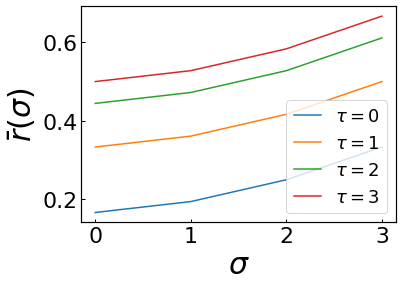

In [7]:
sampling = NodalSampling(sigma=sigma, tau=tau, kappa=kappa, rho_h=rho, P_kappa=P_kappa, r=r)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\bar{r}(\sigma)$")
for t in sampling.tau:
    plt.plot(sampling.sigma, sampling.r_bar_h()[:,t], label=r"$\tau=$"+str(t))
plt.legend()
print(sampling.r_bar())

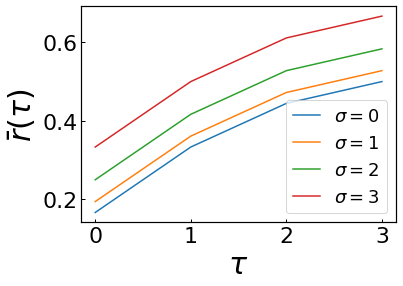

In [8]:
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\bar{r}(\tau)$")
for s in sampling.sigma:
    plt.plot(sampling.tau, sampling.r_bar_h()[s,:], label=r"$\sigma=$"+str(s))
plt.legend()


In [9]:
sampling.r_bar()

0.4305555555555555

(300, 4, 4, 299)


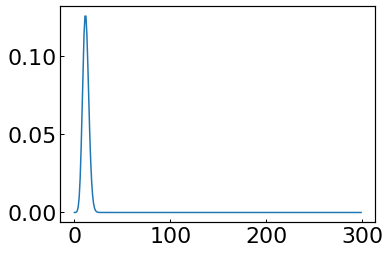

In [10]:
g = sampling.g()
print(g.shape)
plt.plot(sampling.k, g[:,0,0,70])

64.58333333333694

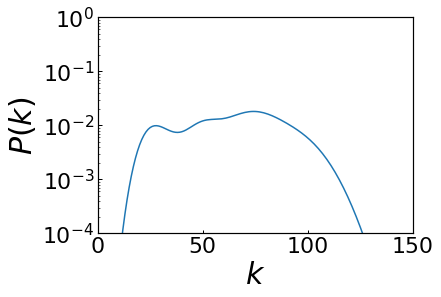

In [11]:
#plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.ylim(1.0e-4,1.0e0)
plt.xlim(0,150)
plt.plot( sampling.k, sampling.P_k() )
np.sum( sampling.k * sampling.P_k() )

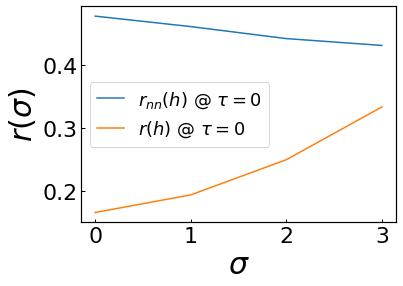

In [12]:
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$r(\sigma)$")
plt.plot(sigma, sampling.r_nn_h()[:,0], label=r"$r_{nn}(h)$ @ $\tau=0$")
plt.plot(sigma, sampling.r_bar_h()[:,0], label=r"$r(h)$ @ $\tau=0$")
plt.legend()

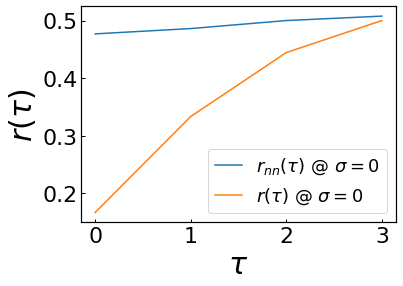

In [13]:
plt.xlabel(r"$\tau$")
plt.ylabel(r"$r(\tau)$")
plt.plot(tau, sampling.r_nn_h()[0,:], label=r"$r_{nn}(\tau)$ @ $\sigma=0$")
plt.plot(tau, sampling.r_bar_h()[0,:], label=r"$r(\tau)$ @ $\sigma=0$")
plt.legend()

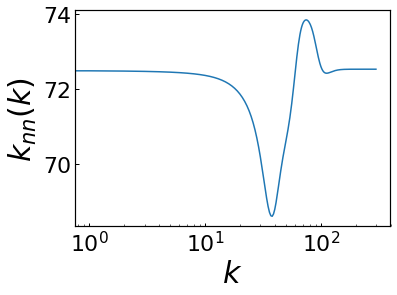

In [14]:
plt.xlabel(r"$k$")
plt.ylabel(r"$k_{nn}(k)$")
kappa_mean = np.sum(kappa * P_kappa)
kappa_nn = np.full(kappa.shape, kappa_mean + 1)
k_nn = sampling.k_nn_k(kappa_nn)
plt.xscale("log")
#plt.xlim(1.0e0, 1.0e2)
plt.plot(sampling.k, k_nn)

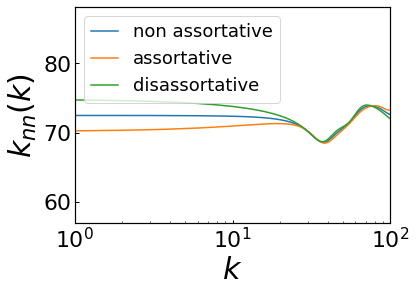

In [15]:
plt.xlabel(r"$k$")
plt.ylabel(r"$k_{nn}(k)$")

kappa_mean = np.sum(kappa * P_kappa)
kappa_nn = np.full(kappa.shape, kappa_mean + 1)
k_nn = sampling.k_nn_k(kappa_nn)
plt.xscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.plot(sampling.k, k_nn, label="non assortative")

kappa_nn = np.full(kappa.shape, kappa_mean + 1 + kappa*0.2-30)
k_nn = sampling.k_nn_k(kappa_nn)
plt.plot(sampling.k, k_nn, label="assortative")

kappa_nn = np.full(kappa.shape, kappa_mean + 1 - kappa*0.2+30)
k_nn = sampling.k_nn_k(kappa_nn)
plt.plot(sampling.k, k_nn, label="disassortative")
plt.legend(loc="upper left")


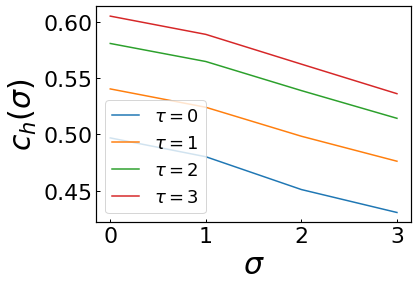

In [16]:
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$c_{h}(\sigma)$")
for t in sampling.tau:
    plt.plot(sampling.sigma, sampling.c_h()[:,t], label=r"$\tau=$"+str(t))
plt.legend()

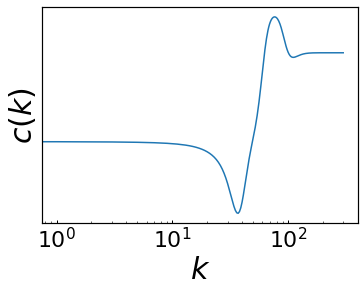

In [17]:
c_o_kappa = np.full( kappa.shape, 0.05 )
plt.xlabel(r"$k$")
plt.ylabel(r"$c(k)$")
plt.yscale("log")
plt.xscale("log")
plt.plot(sampling.k, sampling.c_k(c_o_kappa))

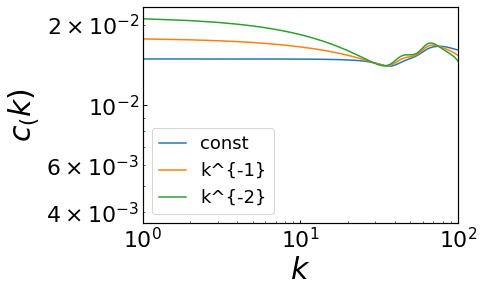

In [18]:
plt.xlabel(r"$k$")
plt.ylabel(r"$c_(k)$")

c_o = 0.03 # fix the original clustering coefficient
c_o_kappa = np.full(kappa.shape, c_o)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1.0e0, 1.0e2)
plt.plot(sampling.k, sampling.c_k(c_o_kappa), label="const")

c_o_kappa = 1.0 / kappa
c_o_kappa = c_o_kappa / np.sum(c_o_kappa * P_kappa) * 0.03
plt.plot(sampling.k, sampling.c_k(c_o_kappa), label="k^{-1}")
plt.legend(loc="best")

c_o_kappa = 1.0 / (kappa**2)
c_o_kappa = c_o_kappa / np.sum(c_o_kappa * P_kappa) * 0.03
plt.plot(sampling.k, sampling.c_k(c_o_kappa), label="k^{-2}")
plt.legend(loc="best")


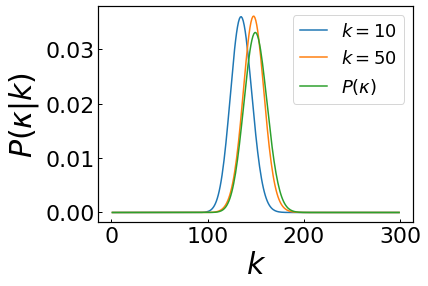

In [19]:
plt.xlabel(r"$k$")
plt.ylabel(r"$P(\kappa|k)$")

g_star_k_kappa = np.sum(sampling.g_star(), axis=(1,2))
plt.plot(kappa, g_star_k_kappa[10,:], label=r"$k = 10$")
plt.plot(kappa, g_star_k_kappa[50,:], label=r"$k = 50$")
plt.plot(kappa, P_kappa, label =r"$P(\kappa)$")
plt.legend()

In [20]:
def _sigma_nn_h():
    # sigma1,tau1, sigma2,tau2 are axis=0,1,2,3 respectively.
    ns = sigma.shape[0]
    nt = tau.shape[0]
    sigma2 = np.copy(sigma).reshape( (1,1,ns,1) )
    tau2 = np.copy(tau).reshape( (1,1,1,nt) )
    rho_h2 = sampling.rho_h.reshape( (1,1,ns,nt) )
    sigma1 = sigma.reshape( (ns,1,1,1) )
    tau1 = tau.reshape( (1,nt,1,1) )
    r_bar_h = sampling.r_bar_h().reshape( (ns,nt,1,1) )
    return np.sum( r(sigma1,tau1,sigma2,tau2)*rho_h2*sigma2 / r_bar_h, axis=(2,3) )

def _tau_nn_h():
    # sigma1,tau1, sigma2,tau2 are axis=0,1,2,3 respectively.
    ns = sigma.shape[0]
    nt = tau.shape[0]
    sigma2 = np.copy(sigma).reshape( (1,1,ns,1) )
    tau2 = np.copy(tau).reshape( (1,1,1,nt) )
    rho_h2 = sampling.rho_h.reshape( (1,1,ns,nt) )
    sigma1 = sigma.reshape( (ns,1,1,1) )
    tau1 = tau.reshape( (1,nt,1,1) )
    r_bar_h = sampling.r_bar_h().reshape( (ns,nt,1,1) )
    return np.sum( r(sigma1,tau1,sigma2,tau2)*rho_h2*tau2 / r_bar_h, axis=(2,3) )


sigma_nn = _sigma_nn_h()
tau_nn = _tau_nn_h()
#plt.plot( sigma, hnn[:,3] )
#plt.plot( tau, hnn[1,:] )
np.sum( sigma_nn * sampling.r_bar_h(), axis=1)

array([2.72222222, 2.72222222, 2.83333333, 3.16666667])

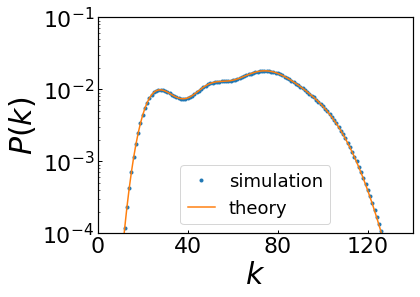

In [21]:
# compare with simulations

# result_dir = "/Users/murase/work/oacis/public/Result_development/5c1afd04d12ac67b76ff6fbe/5c1b114ed12ac6433d77c469/5c1b64a7d12ac6433c976e62/"
result_dir = "sim_result/fig4/"
savefig = False

def _compare_Pk(result_dir):
    path = result_dir + "degree_distribution_ave.dat"
    d = np.loadtxt(path)
    plt.yscale("log")
    plt.ylim(1.0e-4,1.0e-1)
    plt.xlim(0,140)
    plt.xlabel(r"$k$")
    plt.ylabel(r"$P(k)$")
    plt.xticks(np.arange(0, 160, step=40))
    plt.plot(d[:,0], d[:,1]/50000, '.', label='simulation')
    plt.plot( sampling.k, sampling.P_k(), label='theory')
    plt.legend(loc="lower center")
    if savefig:
        plt.savefig("vec_pk_sim.pdf")
    
_compare_Pk(result_dir)

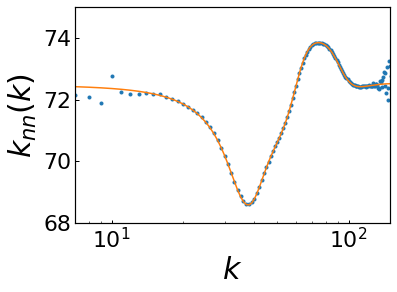

In [22]:
def _compare_knn(result_dir):
    path = result_dir + "neighbor_degree_correlation_ave.dat"
    d = np.loadtxt(path)
    plt.xlabel(r"$k$")
    plt.ylabel(r"$k_{nn}(k)$")
    kappa_mean = np.sum(kappa * P_kappa)
    kappa_nn = np.full(kappa.shape, kappa_mean + 1)
    k_nn = sampling.k_nn_k(kappa_nn)
    plt.xscale("log")
    plt.xlim(7.0e0, 1.5e2)
    plt.ylim(68,75)
    plt.yticks(np.arange(68,75,step=2) )
    plt.plot(d[:,0], d[:,1], '.')
    plt.plot(sampling.k, k_nn)
    if savefig:
        plt.savefig("vec_knn_sim.pdf")

_compare_knn(result_dir)

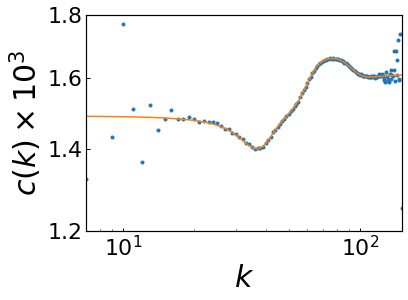

In [23]:
import matplotlib

def _compare_ck(result_dir):
    path = result_dir + "cc_degree_correlation_ave.dat"
    d = np.loadtxt(path)
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel(r"$k$")
    ax1.set_ylabel(r"$c(k) \times 10^3$")
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_xlim(7.0e0, 1.5e2)
    ax1.set_yticks([1.2,1.4,1.6,1.8])
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.set_ylim(1.2, 1.8)
    ax1.plot(d[:,0], d[:,1]*1e3, '.')
    c_o_kappa = np.full( kappa.shape, 0.003 )
    plt.plot( sampling.k[2:], sampling.c_k(c_o_kappa)[2:]*1e3)
    if savefig:
        plt.savefig("vec_ck_sim.pdf")

_compare_ck(result_dir)

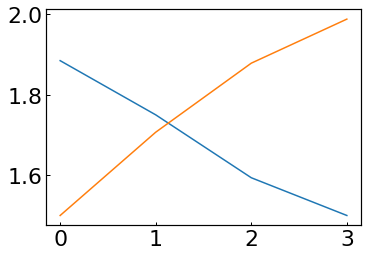

In [24]:
def _sigma_nn_h():
    # sigma1,tau1, sigma2,tau2 are axis=0,1,2,3 respectively.
    ns = sigma.shape[0]
    nt = tau.shape[0]
    sigma2 = np.copy(sigma).reshape( (1,1,ns,1) )
    tau2 = np.copy(tau).reshape( (1,1,1,nt) )
    rho_h2 = sampling.rho_h.reshape( (1,1,ns,nt) )
    sigma1 = sigma.reshape( (ns,1,1,1) )
    tau1 = tau.reshape( (1,nt,1,1) )
    r_bar_h = sampling.r_bar_h().reshape( (ns,nt,1,1) )
    return np.sum( r(sigma1,tau1,sigma2,tau2)*rho_h2*sigma2 / r_bar_h, axis=(2,3) )

def _tau_nn_h():
    # sigma1,tau1, sigma2,tau2 are axis=0,1,2,3 respectively.
    ns = sigma.shape[0]
    nt = tau.shape[0]
    sigma2 = np.copy(sigma).reshape( (1,1,ns,1) )
    tau2 = np.copy(tau).reshape( (1,1,1,nt) )
    rho_h2 = sampling.rho_h.reshape( (1,1,ns,nt) )
    sigma1 = sigma.reshape( (ns,1,1,1) )
    tau1 = tau.reshape( (1,nt,1,1) )
    r_bar_h = sampling.r_bar_h().reshape( (ns,nt,1,1) )
    return np.sum( r(sigma1,tau1,sigma2,tau2)*rho_h2*tau2 / r_bar_h, axis=(2,3) )


sigma_nn = _sigma_nn_h()
tau_nn = _tau_nn_h()
normed_r_bar_h = sampling.r_bar_h() / np.sum( sampling.r_bar_h(), axis=(0,1) )
#plt.plot( sigma, hnn[:,3] )
#plt.plot( tau, hnn[1,:] )
sigma_nn_theor = np.sum( sigma_nn * normed_r_bar_h, axis=1) / np.sum( normed_r_bar_h, axis=1 )
plt.plot(sigma, sigma_nn_theor)

tau_nn_theor = np.sum( tau_nn * normed_r_bar_h, axis=0) / np.sum(normed_r_bar_h, axis=0)
plt.plot(tau,tau_nn_theor)

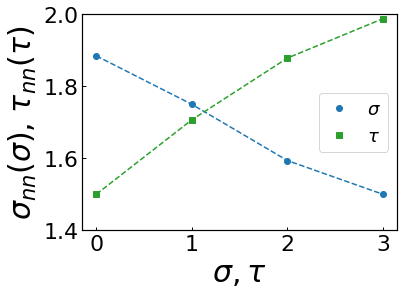

In [25]:
def _compare_hnn(result_dir, x, sigma_nn_theor, tau_nn_theor):
    path = result_dir + "fnn.dat"
    d = np.loadtxt(path)
    plt.xlabel(r"$\sigma,\tau$")
    plt.ylabel(r"$\sigma_{nn}(\sigma)$, $\tau_{nn}(\tau)$")
    plt.ylim(1.4,2.0)
    plt.plot(d[:,0],d[:,1], 'o', label=r"$\sigma$",zorder=10, color='#1f77b4')
    plt.plot(x, sigma_nn_theor, '--', color='#1f77b4')
    plt.plot(d[:,0],d[:,2], 's', label=r"$\tau$",zorder=20, color='#2ca02c')
    plt.plot(x, tau_nn_theor, '--', color='#2ca02c')
    plt.yticks( np.arange(1.4,2.1,step=0.2) )
    plt.legend()
    if savefig:
        plt.savefig("vec_hnn_sim.pdf")

# fnn_result_dir = "/Users/murase/work/oacis/public/Result_development/5c1afd04d12ac67b76ff6fbe/5c1b114ed12ac6433d77c469/5c1b64a7d12ac6433c976e63/"
fnn_result_dir = result_dir
_compare_hnn(fnn_result_dir, sigma, sigma_nn_theor, tau_nn_theor)
